In [1]:
import numpy as np
import scipy as sc
from numba import jit, float64
import matplotlib.pyplot as plt

## Chambolle-Pock

Problem:
$$\textrm{minimize} \left\lVert x \right\rVert _1 \textrm{subject to } Ax=b$$
or
$$\textrm{minimize} \left\lVert x \right\rVert _1 + \delta_{b}(Ax)$$
Algorithm for a problem $\textrm{minimize} f(x) + g(Ax)$:
$$x_{n+1} = \mathrm{prox}_{\lambda f}(x_n - \lambda A^T\omega_n)$$
$$w_{n+1} = \mathrm{prox}_{\beta g^*}(\omega_n+\beta A(2x_{n+1}-x_n)) $$
where $g^*(x^*) = \langle x^*, b \rangle$

In [5]:
# prox_{\lambda f}
@jit
def prox_f(x, step):
    vec = np.abs(x) - step
    vec[vec<0] = 0
    return np.sign(x)*vec


#prox_{\sigma g*}
@jit
def prox_g(x, b, step):
    return x - step*b

In [6]:
def l1_chambolle_pock(A, b, lambd, beta, N, **kwargs):
    x = kwargs.get('x0', np.zeros(A.shape[1]))
    omega = kwargs.get('omega0', np.zeros(A.shape[0]))
    sol = chambolle_pock(A, b, lambd, beta, N, x, omega)
    return sol

@jit
def chambolle_pock(A, b, lambd, beta, N, x, omega):
    A_t = A.T
    x_next = prox_f(x-lambd*np.dot(A_t, omega), lambd)
    omega_next = prox_g(omega + beta*np.dot(A, 2*x_next - x), b, beta)
    n = 1
    while n < N:
        x = x_next
        omega = omega_next
        x_next = prox_f(x-lambd*np.dot(A_t, omega), lambd)
        omega_next = prox_g(omega + beta*np.dot(A, 2*x_next - x), b, beta)
        n += 1
        # print("m = {}  {}% done".format(len(b), round(n/N*100, 2)), end='\r', flush=True)
    return x_next

In [4]:
@jit
def chambolle_pock(A, b, lambd, beta, N, x, omega):
    A_t = A.T
    x_next = prox_f(x-lambd*np.dot(A_t, omega), lambd)
    omega_next = prox_g(omega + beta*np.dot(A, 2*x_next - x), b, beta)
    n = 1
    while n < N:
        x = x_next
        omega = omega_next
        x_next = prox_f(x-lambd*np.dot(A_t, omega), lambd)
        omega_next = prox_g(omega + beta*np.dot(A, 2*x_next - x), b, beta)
        n += 1
        # print("m = {}  {}% done".format(len(b), round(n/N*100, 2)), end='\r', flush=True)
    return x_next

In [8]:
x_test = np.array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0])
A_test = np.random.normal(size=(8, 10))
y_test = np.matmul(A_test, x_test)
xs_test = [l1_chambolle_pock(A_test, y_test, 0.05, 0.05, N) for N in [300, 400, 500, 600, 700, 800, 900, 1000]]

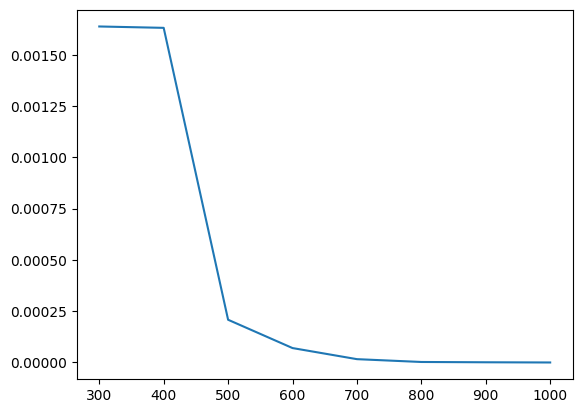

In [9]:
plt.plot([300, 400, 500, 600, 700, 800, 900, 1000], [np.linalg.norm(xx-x_test) for xx in xs_test])

In [10]:
A = np.random.normal(size=(10, 100))
np.linalg.norm(A, ord=2)**2

np.float64(143.72090200928727)

$2s \log{\frac{N}{s}} + \frac{5}{4}s + 1$ random Gaussian measurements suffice to recover the s-sparse vector

In [11]:
s = 10
N = 100
2*s*np.log(N/s) + 5/4*s + 1

np.float64(59.55170185988092)

In [12]:
x = np.zeros(100)
x[np.random.choice(range(0, 100), size=10, replace=False)] = np.random.randint(0, 2, 10)*2-1
ms = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
As = [[np.random.normal(size=(m, 100)) for m in ms] for i in range(10)]
ys = [[np.matmul(A, x) for A in A_sizes]for A_sizes in As]
x

array([ 0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])

In [13]:
solutions2 = [[l1_chambolle_pock(A, y, 0.01, 0.01, N=5000) for (A, y) in zip(A_sizes, y_sizes)] 
             for (A_sizes, y_sizes) in zip(As, ys)]

In [14]:
errors = np.array([[np.linalg.norm(sol - x) for sol in solutions_sizes] for solutions_sizes in solutions2])
success = np.zeros(errors.shape)
success[errors<0.001] = 1
success.sum(axis=0)

array([ 0.,  0.,  0.,  5.,  8., 10., 10., 10., 10., 10.])

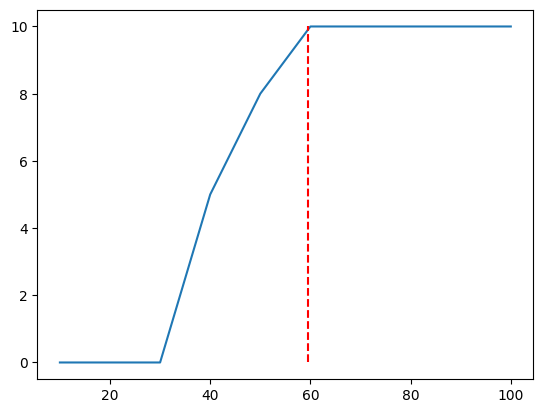

In [15]:
plt.plot(ms, success.sum(axis=0))
s = 10
N = 100
plt.vlines(2*s*np.log(N/s) + 5/4*s + 1, ymin=0, ymax=10, colors='red', linestyles='dashed')
plt.show()

plot matrix of successes with different s (imshow)
living on the edge paper

In [12]:
'''
A: axis0 - varying m
   axis1 - different random matrices
x: axis0 - varying s
y: axis0 - varying s
   axis1 - varying m
   axis2 - different random matrices
'''

'\nA: axis0 - varying m\n   axis1 - different random matrices\nx: axis0 - varying s\ny: axis0 - varying s\n   axis1 - varying m\n   axis2 - different random matrices\n'

In [16]:
def phase_trans(dim, sparse_step, mesure_step, n_of_tests, n_iter=5000):

    x = np.zeros(shape=(dim//sparse_step+1, dim))
    for i in range(0, dim//sparse_step+1):
        non_sparse = np.random.choice(range(0, dim), size = i*sparse_step, replace=False)
        x[i, non_sparse] = np.random.randint(0, 2, size=non_sparse.shape[0])*2-1
    ms = np.linspace(mesure_step, dim, dim//mesure_step, dtype=int)
    As = [[np.random.normal(size=(m, dim)) for i in range(n_of_tests)] for m in ms]
    ys = [[[np.matmul(A, x_s) for A in As[i]] for i in range(len(ms))] for x_s in x]

    solutions = np.zeros((x.shape[0], len(ms), len(As[0]), dim))

    count = 0 
    for i in range(len(x)):
        for j in range(len(ms)):
            for k in range(n_of_tests):
                solutions[i][j][k] = l1_chambolle_pock(As[j][k], ys[i][j][k], 0.01, 0.01, N=n_iter)
                # print(f"s = {i*sparse_step:3d}, m = {(j+1)*mesure_step:3d}, test #{k:3d}/{n_of_tests}")
                count += 1
                if count%10==0: 
                    print("{:2f}% done".format(count/(len(x)*len(ms)*n_of_tests)*100), end='\r')

    return solutions, x
    

In [ ]:
res, x = phase_trans(100, 1, 1, 10, n_iter=10000)

In [65]:
error = np.zeros(res.shape[:-1])
for i in range(res.shape[0]):
    for j in range(res.shape[1]):
        for k in range(res.shape[2]):
            error[i, j, k] = np.linalg.norm(res[i, j, k] - x[i])
is_successful = np.zeros(res.shape[:-1])
is_successful[error<0.001] = 1
is_successful.sum(axis=2)

array([[10., 10., 10., ..., 10., 10., 10.],
       [ 0.,  2.,  0., ..., 10., 10., 10.],
       [ 0.,  0.,  0., ..., 10., 10., 10.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], shape=(101, 100))

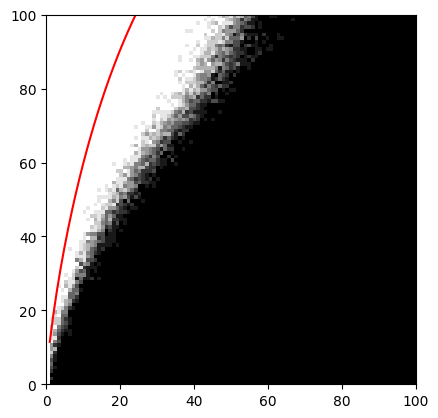

In [66]:
s = np.linspace(1, 100, 100)
crit = 2*s*np.log(100/s) + 5/4*s + 1
plt.plot(s, crit, c='red')
plt.imshow(is_successful.sum(axis=2).T, cmap='binary', extent=[0, 100, 0, 100], origin='lower')
plt.show()

In [2]:
import cvxpy as cp

In [3]:
def phase_trans_cvxpy(dim, sparse_step, mesure_step, n_of_tests):

    x = np.zeros(shape=(dim//sparse_step+1, dim))
    for i in range(0, dim//sparse_step+1):
        non_sparse = np.random.choice(range(0, dim), size = i*sparse_step, replace=False)
        x[i, non_sparse] = np.random.randint(-100, 100, size=non_sparse.shape[0])
    ms = np.linspace(mesure_step, dim, dim//mesure_step, dtype=int)
    As = [[np.random.normal(size=(m, dim)) for i in range(n_of_tests)] for m in ms]
    ys = [[[np.matmul(A, x_s) for A in As[i]] for i in range(len(ms))] for x_s in x]

    solutions = np.zeros((x.shape[0], len(ms), len(As[0]), dim))

    count = 0 
    for i in range(len(x)):
        for j in range(len(ms)):
            for k in range(n_of_tests):
                sol = cp.Variable(shape=x.shape[1])
                constr = [As[j][k]@sol == ys[i][j][k]]
                obj = cp.Minimize(cp.norm(sol, 1))
                prob = cp.Problem(obj, constr)
                prob.solve()
                solutions[i][j][k] = sol.value
                # print(f"s = {i*sparse_step:3d}, m = {(j+1)*mesure_step:3d}, test #{k:3d}/{n_of_tests}")
                count += 1
                if count%10==0: 
                    print("{:2f}% done".format(count/(len(x)*len(ms)*n_of_tests)*100), end='\r')

    return solutions, x

In [30]:
res_cvxpy, x_cvxpy = phase_trans_cvxpy(100, 1, 1, 10)
# np.save("dim100_num_solutions.npy", res_cvxpy)
# np.save("dim100_true_solution.npy", x_cvxpy)

/home/lizardwizard/venv-math/lib/python3.13/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [10]:
res_cvxpy500, x_cvxpy500 = phase_trans_cvxpy(300, 1, 1, 10)
np.save("dim500_num_solutions.npy", res_cvxpy500)
np.save("dim500_true_solution.npy", x_cvxpy500)

KeyboardInterrupt: 

In [31]:
res_cvxpy = np.load("dim100_num_solutions.npy")
x_cvxpy = np.load("dim100_true_solution.npy")

In [32]:
error_cvxpy = np.zeros(res_cvxpy.shape[:-1])
for i in range(res_cvxpy.shape[0]):
    for j in range(res_cvxpy.shape[1]):
        for k in range(res_cvxpy.shape[2]):
            error_cvxpy[i, j, k] = np.linalg.norm(res_cvxpy[i, j, k] - x_cvxpy[i])
is_successful = np.zeros(res_cvxpy.shape[:-1])
is_successful[error_cvxpy<0.0001] = 1
is_successful.sum(axis=2)

array([[10., 10., 10., ..., 10., 10., 10.],
       [ 0.,  0.,  1., ..., 10., 10., 10.],
       [ 0.,  0.,  0., ..., 10., 10., 10.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  1., 10.],
       [ 0.,  0.,  0., ...,  0.,  1., 10.],
       [ 0.,  0.,  0., ...,  0.,  0., 10.]], shape=(101, 100))

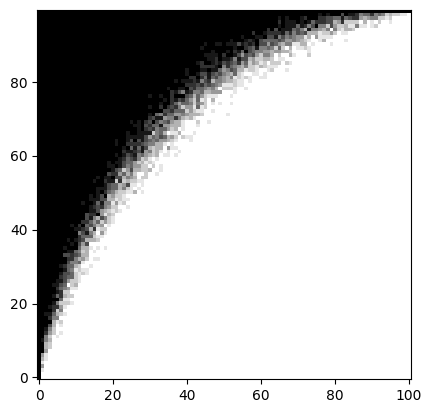

In [36]:
plt.imshow(is_successful.sum(axis=2).T, cmap="binary", origin="lower")

In [37]:
from math import erf

In [38]:
def eq46(tau, ro):
    return np.sqrt(2/np.pi)/tau*np.e**(-0.5*tau**2) - (1-erf(tau*np.sqrt(0.5))) - ro/(1-ro)

def psi(ro, tau):
    integral =  (1+tau**2)*(1-erf(tau*np.sqrt(0.5))) - np.sqrt(2/np.pi)*tau*np.e**(-tau**2*0.5)
    return ro*(1+tau**2) + (1-ro)*integral

In [40]:
s = np.linspace(1, 99, 99)
psi_ro = np.zeros(99)
for i in range(99):
    tau_opt = sc.optimize.root_scalar(lambda tau: eq46(tau, s[i]/100), bracket=(0.0001, 5)).root
    psi_ro[i] = psi(s[i]/100, tau_opt)

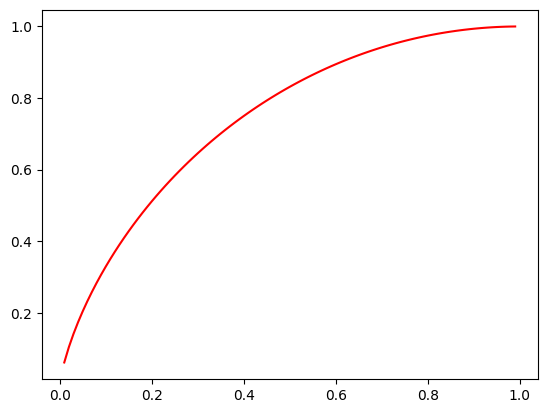

In [41]:
plt.plot(s/100, psi_ro, c='red')

In [42]:
stat_dim_lower = 100*psi_ro - 100*2/np.sqrt(s*100)
stat_dim_upper = 100*psi_ro

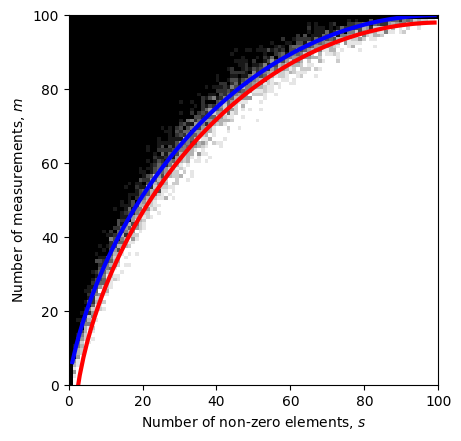

In [46]:
plt.plot(s, stat_dim_lower, c='red', linewidth=3)
plt.plot(s, stat_dim_upper, c='blue', linewidth=3)
plt.imshow(is_successful.sum(axis=2).T, cmap='binary', extent=[0, 100, 0, 100], origin='lower')
plt.xlabel("Number of non-zero elements, $s$")
plt.ylabel("Number of measurements, $m$")
plt.show()

In [73]:
def transition_phase(prob, dim=100, N_points=100):
    s = np.linspace(1, dim-1, N_points-1)
    psi_ro = np.zeros(N_points-1)
    for i in range(N_points-1):
        tau_opt = sc.optimize.root_scalar(lambda tau: eq46(tau, s[i]/dim), bracket=(0.0001, 5)).root
        psi_ro[i] = psi(s[i]/dim, tau_opt)
    stat_dim_lower = dim * psi_ro - dim * 2 / np.sqrt(s * dim)
    stat_dim_upper = dim * psi_ro
    m_lower = stat_dim_upper + np.sqrt(8*np.log(4/prob))*np.sqrt(dim)
    m_upper = stat_dim_lower - np.sqrt(8*np.log(4/prob))*np.sqrt(dim)
    return (m_lower, m_upper, stat_dim_lower, stat_dim_upper)

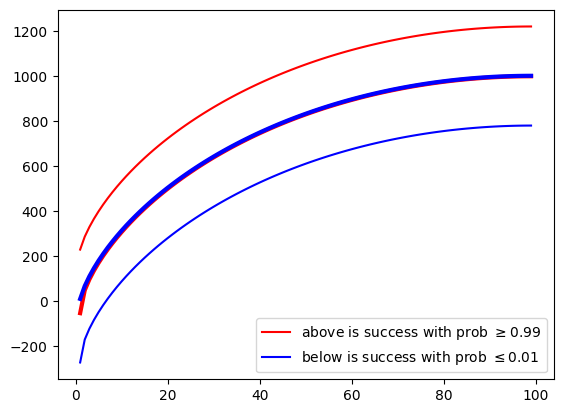

In [85]:
eta = 0.01
m_low, m_up, stat_dim_lower, stat_dim_upper = transition_phase(eta, dim=1000, N_points=100)
plt.plot(s, m_low, c='red', label=f"above is success with prob $\\geq {round(1-eta, 2)}$")
plt.plot(s, m_up, c='blue', label=f"below is success with prob $\\leq {eta}$")
plt.plot(s, stat_dim_lower, c='red', linewidth=3)
plt.plot(s, stat_dim_upper, c='blue', linewidth=3)
plt.legend()


In [64]:
eta = 0.05
m_lower, m_upper = transition_phase(eta)

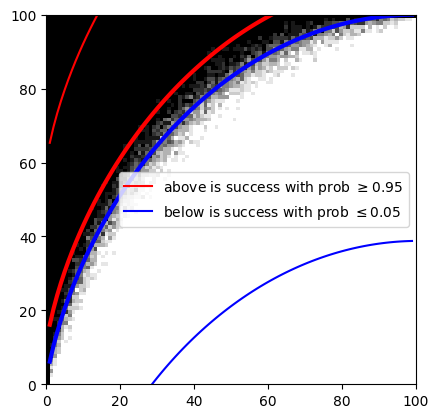

In [70]:
plt.plot(s, m_lower, c='red', label=f"above is success with prob $\\geq {round(1-eta, 2)}$")
plt.plot(s, m_upper, c='blue', label=f"below is success with prob $\\leq {eta}$")
plt.plot(s, stat_dim_upper+10, c='red', linewidth=3)
plt.plot(s, stat_dim_upper, c='blue', linewidth=3)
plt.imshow(is_successful.sum(axis=2).T, cmap='binary', extent=(0, 100, 0, 100), origin='lower')
plt.legend()
plt.show()